In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("spam.csv")
df = df[["v1", "v2"]]
df.rename(columns={
    "v1": "Category",
    "v2" : "Message"
}, inplace=True)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.Category.value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

(array([4825.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         747.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

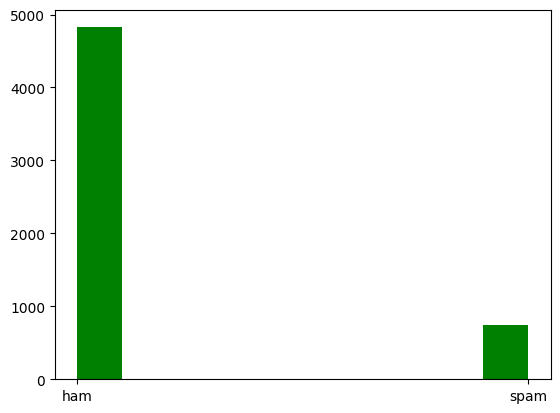

In [4]:
plt.hist(df["Category"], color="green")

In [5]:
df1 = df[df["Category"] == "ham"]
df0 = df[df["Category"] == "spam"]
df1.shape

(4825, 2)

In [6]:
df0 = df0.sample(df1.shape[0], replace=True)
df1 = pd.concat([df1, df0], axis=0)
df1.Category.value_counts()

Category
ham     4825
spam    4825
Name: count, dtype: int64

(array([4825.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4825.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

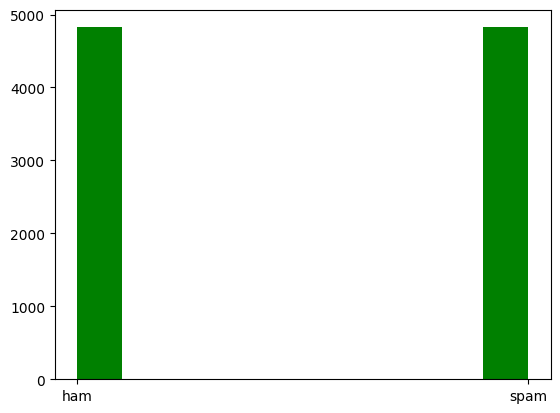

In [7]:
plt.hist(df1["Category"], color="g")

In [8]:
import spacy

nlp = spacy.load("en_core_web_lg")

def processing(text):
    tokens = nlp(text)
    filtered_tokens = []
    for token in tokens:
        if token.is_stop:
            continue
        filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)

In [9]:
x = df1.Message.apply(processing)


In [10]:
len(x[0]),  len(df["Message"][0])
x[0], df["Message"][0]

('jurong point , crazy .. available bugis n great world la e buffet ... cine get amore wat ...',
 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')

In [11]:
y = df1["Category"].map({
    "ham":1,
    "spam":0
})
y.value_counts()

Category
1    4825
0    4825
Name: count, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=df1["Category"])

In [13]:
x_train.shape, x_test.shape, y_train.value_counts()

((6755,),
 (2895,),
 Category
 1    3378
 0    3377
 Name: count, dtype: int64)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer()

x_train = tf.fit_transform(x_train)
x_train.shape

(6755, 6613)

In [15]:
x_test = tf.transform(x_test)
x_test.shape


(2895, 6613)

In [16]:
y_train[:5]

3625    1
2296    0
4380    1
3748    0
1068    0
Name: Category, dtype: int64

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
ran = RandomForestClassifier(n_estimators=100)
dec = DecisionTreeClassifier()

models = {
    "RandomForest" : ran,
    "DesisionTree": dec,
    "LogisticRegression" : LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(gamma="auto", kernel="rbf"),
    "Naive Bayes": MultinomialNB()
}

In [18]:
#Training the dataset with different types of models
scores = []
for name, var in models.items():
    var.fit(x_train, y_train)
    y_predict = var.predict(x_test)
    scores.append({
        "Model_name": name,
        "Test Accuracy": var.score(x_test, y_test), 
        # "Accuracy": accuracy_score(y_test,y_predict),
        "precision" : precision_score(y_test, y_predict, zero_division=0),
        "recall" : recall_score(y_test, y_predict),
        "f1_score" : f1_score(y_test, y_predict)
        
    })
df1 = pd.DataFrame(scores)
df1

,Model_name,Test Accuracy,precision,recall,f1_score
0,RandomForest,0.998964,1.000000,0.997927,0.998962
1,DesisionTree,0.988946,0.997889,0.979959,0.988842
2,LogisticRegression,0.987219,0.981557,0.993089,0.987290
3,Support Vector Machine,0.499827,0.499827,1.000000,0.666513
4,Naive Bayes,0.974093,0.981066,0.966828,0.973895


In [19]:
#Random forest has the higher  accuracy

ran.fit(x_train, y_train)
y_pred = ran.predict(x_test)
y_test = np.array(y_test)
y_predict[:5], y_test[:5]

(array([0, 1, 0, 0, 1], dtype=int64), array([1, 1, 0, 0, 1], dtype=int64))

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1448
           1       0.98      0.97      0.97      1447

    accuracy                           0.97      2895
   macro avg       0.97      0.97      0.97      2895
weighted avg       0.97      0.97      0.97      2895



In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm

array([[1448,    0],
       [   4, 1443]], dtype=int64)

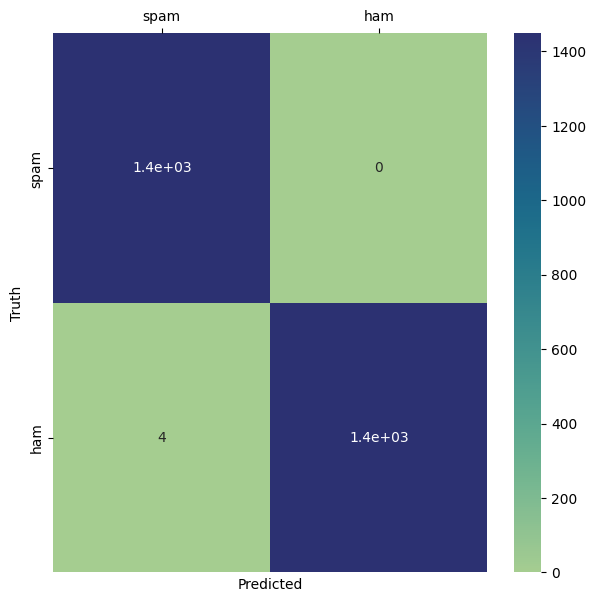

In [24]:
#Visualising the condfusion matrix in heat map
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(7,7))
ax= sn.heatmap(cm, annot=True, cmap="crest")
plt.xlabel("Predicted")
plt.ylabel("Truth")
ax.xaxis.set_ticklabels(["spam", "ham"])
ax.yaxis.set_ticklabels(["spam", "ham"])
ax.xaxis.tick_top()